# INTRODUCTION
> The traditional supervised learning paradigm breaks down when we do not have sufficient labeled data for the task or domain we care about to train a reliable model.
> For example, if we want to train a model to detect pedestrians on night-time images, we could apply a model that has been trained on a similar domain, e.g. on day-time images. In practice, however, we often experience a deterioration or collapse in performance as the model has inherited the bias of its training data and does not know how to generalize to the new domain.
> Transfer learning allows us to deal with these scenarios by leveraging the already existing labeled data of some related task or domain. 

> Here we will see one application of transfer learning on detecting pneumonia using chest x-rays.

# VGG16  

![VGG16 Architecture](https://packt-type-cloud.s3.amazonaws.com/uploads/sites/3149/2018/11/61d69a2a-f31c-477b-9197-b1764c2658b1.png)

**Figure 1:** VGG16 architecture (from https://hub.packtpub.com/how-to-leverage-transfer-learning-using-pretrained-cnn-models-tutorial/)

> ImageNet is a research project to develop a large database of images with annotations e.g. images and their labels.
Pretrained models like VGG-16 and VGG-19 are already trained on ImageNet which comprises of disparate categories of images. These models are built from scratch and trained by using high GPU’s over millions of images consisting of thousands of image categories. 

> As the model is trained on huge dataset, it has learned a good representation of low level features like spatial, edges, rotation, lighting, shapes and these features can be shared across to enable the knowledge transfer and act as a feature extractor for new images in different computer vision problems. These new images might be of completely different categories from the source dataset, but the pretrained model should still be able to extract relevant features from these images based on the principles of transfer learning.

# *Please upvote the kernel if you find it insightful!*


# Import Libraries

In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
# import skimage
# from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

# Load Dataset
The dataset respective to already classified category is divided into three sets:
* test set
* train set
* validation set


In [12]:
EPOCHS = 30
data_dir = "C:/Users/Swati/Desktop/Coding/PROJECT/Medical-AI/models/pneumonia/data"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

# Data Preprocessing and Augmentation
> Deep learning models usually require a lot of data for training. In general, the more the data, the better the performance of the model.

> Image Augmentation is the process of generating new images for training our deep learning model. These new images are generated using the existing training images and hence we don’t have to collect them manually.

In [3]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [13]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) 
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True), 
               VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True), 
               TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)}

In [14]:
len(dataloaders[TRAIN])

2

In [15]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}
classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

In [16]:
class_names

['NORMAL', 'PNEUMONIA']

# Visualize the Chest X-rays

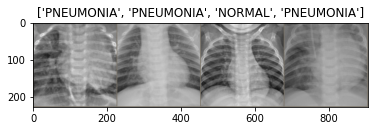

In [17]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders[TRAIN]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [18]:
inputs, classes = next(iter(dataloaders[TRAIN]))

# Define Function for Training

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
#     best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                print('Validation ac increased ({:.6f} --> {:.6f}).  Saving model ...'.format( best_acc,epoch_acc))
                torch.save(model.state_dict(), './model_augmented.pt')
                best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
#     model.load_state_dict(best_model_wts)
    return model

In [ ]:
torch.save(model.state_dict(), './model_augmented.pt')

In [20]:
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

# Load the pretrained model from Pytorch

In [ ]:
# model_pre = models.vgg16()
# model_pre.load_state_dict(torch.load("../input/pytorch-pretrained-models/vgg16-397923af.pth"))

In [21]:
model_pre = models.densenet121()
model_pre.load_state_dict(torch.load('C:/Users/Swati/Desktop/Coding/PROJECT/Medical-AI/models/pneumonia/weights/pne.pt' , map_location=map_location))

RuntimeError: Error(s) in loading state_dict for DenseNet:
	Missing key(s) in state_dict: "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "classifier.0.weight", "classifier.0.bias". 

In [12]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier.in_features
features = list(model_pre.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features) 
print(model_pre)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
torch.save(model_pre.state_dict(), './model.pt')./model.pt

In [ ]:
print(model_pre.classifier)

In [ ]:
print(model_pre.classifier[6])

# Define the Hyperparameters

In [13]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train Phase

In [ ]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/30


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.3293 Acc: 0.8562
val Loss: 1.2642 Acc: 0.6250
Validation ac increased (0.000000 --> 0.625000).  Saving model ...
Epoch: 2/30
train Loss: 0.2228 Acc: 0.9229
val Loss: 1.4940 Acc: 0.5000
Epoch: 3/30
train Loss: 0.1692 Acc: 0.9456
val Loss: 1.3710 Acc: 0.6250
Epoch: 4/30
train Loss: 0.1498 Acc: 0.9503
val Loss: 0.9237 Acc: 0.6875
Validation ac increased (0.625000 --> 0.687500).  Saving model ...
Epoch: 5/30
train Loss: 0.1457 Acc: 0.9563
val Loss: 0.6419 Acc: 0.6875
Epoch: 6/30
train Loss: 0.1189 Acc: 0.9645
val Loss: 0.5800 Acc: 0.6875
Epoch: 7/30
train Loss: 0.1230 Acc: 0.9615
val Loss: 0.5130 Acc: 0.7500
Validation ac increased (0.687500 --> 0.750000).  Saving model ...
Epoch: 8/30
train Loss: 0.1271 Acc: 0.9613
val Loss: 0.6401 Acc: 0.6875
Epoch: 9/30
train Loss: 0.1126 Acc: 0.9638
val Loss: 0.4459 Acc: 0.8750
Validation ac increased (0.750000 --> 0.875000).  Saving model ...
Epoch: 10/30
train Loss: 0.0896 Acc: 0.9751
val Loss: 0.3796 Acc: 0.8125
Epoch: 11/30
train Loss

In [ ]:
model_pre.load_state_dict(torch.load('./model_augmented.pt')) 

# Define Function for Testing

In [ ]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

# Testing Phase

In [ ]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

# Results

In [ ]:
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

**Confusion Matrix, Presision and Recall**

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()
ax = sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
tn , fp , fn , tp

In [ ]:
p = tp / (tp + fp)
p

In [ ]:
r = tp / (tp + fn)
r

In [ ]:
2 * (p *r) / (p +r)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support , f1_score

In [ ]:
precision_recall_fscore_support(true_labels, pred_labels, average='macro')

In [ ]:
precision_recall_fscore_support(true_labels, pred_labels, average='micro')

In [ ]:
f1_score(true_labels, pred_labels, average='macro')